In [3]:
import pandas as pd


use_cols = ['Target Name', 'Ligand SMILES', 'IC50 (nM)', 'Kd (nM)', 'Ki (nM)']
df = pd.read_csv("data/BindingDB_All.tsv", sep="\t", usecols=use_cols)
df_small = df.dropna(subset=['Ligand SMILES'])

C:\Users\Yilin\AppData\Local\Temp\ipykernel_17832\4124671458.py:5: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/BindingDB_All.tsv", sep="\t", usecols=use_cols)


In [4]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from rdkit import Chem
from rdkit.Chem import Descriptors


def calc_mol_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=True)
        if mol is None:
            raise ValueError("Invalid SMILES")
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        h_acceptors = Descriptors.NumHAcceptors(mol)
        return pd.Series([mw, logp, tpsa, h_acceptors])
    except:
        return pd.Series([None, None, None, None])

df_small[['MolWt', 'LogP', 'TPSA', 'HAcceptors']] = df_small['Ligand SMILES'].apply(calc_mol_features)


[12:37:30] Explicit valence for atom # 17 O, 3, is greater than permitted
[12:37:30] Explicit valence for atom # 16 O, 3, is greater than permitted
[12:37:30] Explicit valence for atom # 16 O, 3, is greater than permitted
[12:37:30] Explicit valence for atom # 17 O, 3, is greater than permitted
[12:37:30] Explicit valence for atom # 16 O, 3, is greater than permitted
[12:37:30] Explicit valence for atom # 16 O, 3, is greater than permitted
[12:39:04] Explicit valence for atom # 10 N, 4, is greater than permitted
[12:39:04] Explicit valence for atom # 10 N, 4, is greater than permitted
[12:39:04] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:39:04] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:39:04] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:39:04] Explicit valence for atom # 17 N, 4, is greater than permitted
[12:39:04] Explicit valence for atom # 20 N, 4, is greater than permitted
[12:39:04] Explicit valence for atom # 

In [8]:
import numpy as np


df_small['IC50 (nM)'] = pd.to_numeric(df_small['IC50 (nM)'], errors='coerce')
df_small = df_small[df_small['IC50 (nM)'].notna()]
df_small['pIC50'] = -np.log10(df_small['IC50 (nM)'] * 1e-9)


c:\python\Protein-Ligand-Binding-Predictor\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


X = df_small[['MolWt', 'LogP', 'TPSA', 'HAcceptors']]
y = df_small['pIC50']
mask = ~np.isnan(y) & ~np.isinf(y)
X_clean = X[mask]
y_clean = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

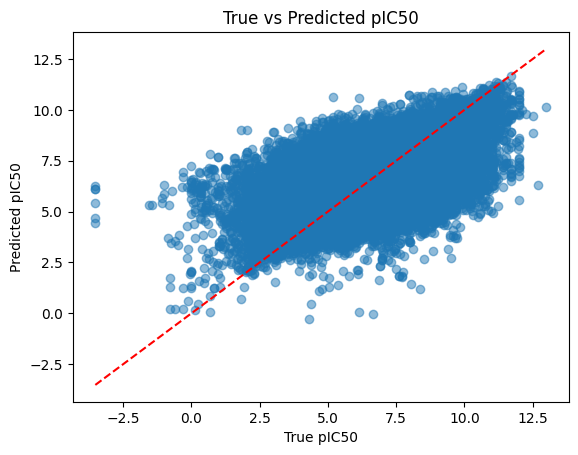

In [14]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True pIC50")
plt.ylabel("Predicted pIC50")
plt.title("True vs Predicted pIC50")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.show()

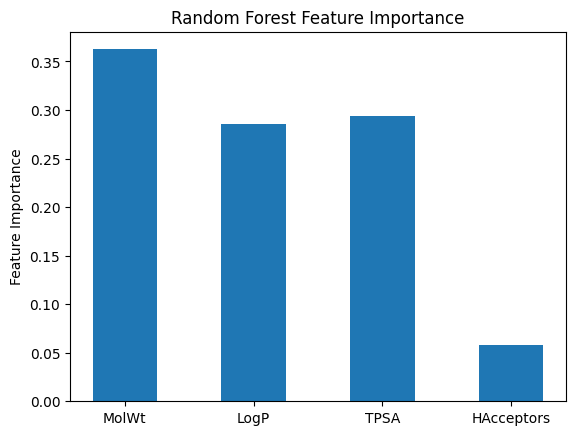

In [16]:
importances = model.feature_importances_
feat_names = X.columns

plt.bar(feat_names, importances, width=0.5)
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()